In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Load dataset

df_train = pd.read_csv('data/Train.csv')
df_test = pd.read_csv('data/Test.csv')
df_sample_submission = pd.read_csv('data/SampleSubmission.csv')

In [3]:
# Creating subsets of locations
#location_groups = df_train.groupby('Place_ID')
#type("location_groups")
#for location, sub_df in location_groups:
    # Sort each subset DataFrame by the 'Date' column in ascending order
#   sub_df = sub_df.sort_values(by='Date', ascending=True)
#  print(f"{location}:{sub_df}")


# Convert 'Date' to datetime if not already done
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Create empty lists to store train and test DataFrames
train_dfs = []
test_dfs = []

# Creating subsets of locations
location_groups = df_train.groupby('Place_ID')

# Filter out groups that have fewer than 13 unique dates
filtered_groups = {
    location: sub_df for location, sub_df in location_groups 
    if sub_df['Date'].nunique() >= 13
}

# Debug: Print number of filtered groups
print(f"Number of filtered groups (locations with >=13 unique dates): {len(filtered_groups)}")

# Iterate through each filtered group
for location, sub_df in filtered_groups.items():
    # Sort each subset DataFrame by the 'Date' column in ascending order
    sub_df = sub_df.sort_values(by='Date', ascending=True)

    # Debug: Check the number of rows in the sorted sub_df
    print(f"Location: {location}, Number of rows: {len(sub_df)}")
    
    # Select the last three rows for the test set
    test_df = sub_df.tail(3)
    # Select the remaining rows for the train set
    train_df = sub_df.iloc[:-3]

     # Create a lag-1 variable for 'target' only in the training set
    train_df['lag_1'] = train_df['target'].shift(1)

    # Drop rows with NaN values in 'lag_1' (due to the shift)
    train_df = train_df.dropna(subset=['lag_1'])

    # Debug: Verify the number of rows in train and test sets for this location
    print(f"Location: {location}, Train Rows: {len(train_df)}, Test Rows: {len(test_df)}")

    # Append the split dataframes to their respective lists
    train_dfs.append(train_df)
    test_dfs.append(test_df)

# Concatenate all the train and test DataFrames into separate DataFrames
df_train_split = pd.concat(train_dfs, ignore_index=True)
df_test_split = pd.concat(test_dfs, ignore_index=True)

# Display or use the resulting DataFrames
print("Training set:")
print(df_train_split.head())  # Display the first few rows for verification
print("\nTest set:")
print(df_test_split.head())   # Display the first few rows for verification

# Optional: Check the number of rows in the test set for each location to verify correctness
print("\nNumber of rows per Place_ID in the test set:")
print(df_test_split['Place_ID'].value_counts())

Number of filtered groups (locations with >=13 unique dates): 337
Location: 010Q650, Number of rows: 94
Location: 010Q650, Train Rows: 90, Test Rows: 3
Location: 05EC30X, Number of rows: 90
Location: 05EC30X, Train Rows: 86, Test Rows: 3
Location: 0DPWHX8, Number of rows: 94
Location: 0DPWHX8, Train Rows: 90, Test Rows: 3
Location: 0GBXTHY, Number of rows: 94
Location: 0GBXTHY, Train Rows: 90, Test Rows: 3
Location: 0HYPV1N, Number of rows: 94
Location: 0HYPV1N, Train Rows: 90, Test Rows: 3
Location: 0I2XREH, Number of rows: 65
Location: 0I2XREH, Train Rows: 61, Test Rows: 3
Location: 0KV6RJ1, Number of rows: 94
Location: 0KV6RJ1, Train Rows: 90, Test Rows: 3
Location: 0MGEY68, Number of rows: 94
Location: 0MGEY68, Train Rows: 90, Test Rows: 3
Location: 0O9R6AD, Number of rows: 92
Location: 0O9R6AD, Train Rows: 88, Test Rows: 3
Location: 0PP73FZ, Number of rows: 94
Location: 0PP73FZ, Train Rows: 90, Test Rows: 3
Location: 0RYZQUU, Number of rows: 91
Location: 0RYZQUU, Train Rows: 87, T

In [4]:
# Check if 'lag_1' exists in the training dataset and move it to the end
if 'lag_1' in df_train_split.columns:
    # Get all columns except 'lag_1'
    cols = [col for col in df_train_split.columns if col != 'lag_1']
    # Add 'lag_1' as the last column
    df_train_split = df_train_split[cols + ['lag_1']]
    print("'lag_1' has been moved to the last position in the training dataset.")
else:
    print("'lag_1' does not exist in the training dataset.")

'lag_1' has been moved to the last position in the training dataset.


In [5]:
# MODEL 2 (incl. date variables)

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Step 1: Sort data by Place_ID and Date
df_train_split = df_train_split.sort_values(by=['Place_ID', 'Date'])
df_test_split = df_test_split.sort_values(by=['Place_ID', 'Date'])

# Step 2: Create 'day_number' and 'is_weekend' features

# Convert 'Date' to datetime format if not already done
df_train_split['Date'] = pd.to_datetime(df_train_split['Date'])
df_test_split['Date'] = pd.to_datetime(df_test_split['Date'])

# Calculate 'day_number' (days since the first date per Place_ID)
df_train_split['day_number'] = df_train_split.groupby('Place_ID')['Date'].transform(lambda x: (x - x.min()).dt.days)
df_test_split['day_number'] = df_test_split.groupby('Place_ID')['Date'].transform(lambda x: (x - x.min()).dt.days)

# Create 'is_weekend' (1 if weekend, 0 if weekday)
df_train_split['is_weekend'] = df_train_split['Date'].dt.weekday.isin([5, 6]).astype(int)
df_test_split['is_weekend'] = df_test_split['Date'].dt.weekday.isin([5, 6]).astype(int)

# Step 3: Update the feature columns list to include the new features
feature_columns = [
    'temperature_2m_above_ground', 
    'precipitable_water_entire_atmosphere',  
    'Place_ID'
]

feature_columns_lag = feature_columns + ["lag_1"]

# Prepare the training and testing data with the new features
X_train = df_train_split[feature_columns_lag]
y_train = df_train_split['target']
#X_test = df_test_split[feature_columns]
#y_test = df_test_split['target']

# Encode the 'Place_ID' as it is a categorical feature
label_encoder = LabelEncoder()
X_train['Place_ID'] = label_encoder.fit_transform(X_train['Place_ID'])
#X_test['Place_ID'] = label_encoder.transform(X_test['Place_ID'])

# Define the LightGBM model using the scikit-learn API
model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=1000,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42
)

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

# Train the model with early stopping
model.fit(
    X_train_new, y_train_new,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)],
)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

In [6]:
from sklearn.metrics import mean_squared_error
# (on train)
placewise_mean = df_train_split.groupby("Place_ID")["target"].mean()
placewise_mean
baseline_model_pred_train = df_train_split["Place_ID"].apply(lambda x: placewise_mean.loc[x])
baseline_model_pred_train
# Calculate RMSE for the training set predictions
rmse = mean_squared_error(df_train_split["target"], baseline_model_pred_train, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)



Root Mean Squared Error (RMSE): 28.87946451813528


In [15]:

# (on test)
baseline_model_pred_test = df_test_split["Place_ID"].apply(lambda x: placewise_mean.loc[x])
baseline_model_pred_test
# Calculate RMSE for the training set predictions
rmse = mean_squared_error(df_test_split["target"], baseline_model_pred_test, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 24.286136871756664


In [7]:
features_other_than_place_id_or_lag1 = list(set(feature_columns_lag) - set(['Place_ID','lag_1']))
features_other_than_place_id_or_lag1


['temperature_2m_above_ground', 'precipitable_water_entire_atmosphere']

In [8]:
df_train_split.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

In [9]:
df_test_split.groupby("Place_ID")["Date"].count().unique()

array([3])

In [10]:
missing_values_1 = df_test_split.isna().sum()
for c in df_test_split.columns:
    if missing_values_1.loc[c] != 0: 
        print(c)

L3_NO2_NO2_column_number_density
L3_NO2_NO2_slant_column_number_density
L3_NO2_absorbing_aerosol_index
L3_NO2_cloud_fraction
L3_NO2_sensor_altitude
L3_NO2_sensor_azimuth_angle
L3_NO2_sensor_zenith_angle
L3_NO2_solar_azimuth_angle
L3_NO2_solar_zenith_angle
L3_NO2_stratospheric_NO2_column_number_density
L3_NO2_tropopause_pressure
L3_NO2_tropospheric_NO2_column_number_density
L3_O3_O3_column_number_density
L3_O3_O3_effective_temperature
L3_O3_cloud_fraction
L3_O3_sensor_azimuth_angle
L3_O3_sensor_zenith_angle
L3_O3_solar_azimuth_angle
L3_O3_solar_zenith_angle
L3_CO_CO_column_number_density
L3_CO_H2O_column_number_density
L3_CO_cloud_height
L3_CO_sensor_altitude
L3_CO_sensor_azimuth_angle
L3_CO_sensor_zenith_angle
L3_CO_solar_azimuth_angle
L3_CO_solar_zenith_angle
L3_HCHO_HCHO_slant_column_number_density
L3_HCHO_cloud_fraction
L3_HCHO_sensor_azimuth_angle
L3_HCHO_sensor_zenith_angle
L3_HCHO_solar_azimuth_angle
L3_HCHO_solar_zenith_angle
L3_HCHO_tropospheric_HCHO_column_number_density
L3_HC

In [11]:
from datetime import timedelta

def forecast_target(model, place_id):
    """
    spits out forecasted target for test data, given a trained model and a place_id
    """
    sub_train = df_train_split[df_train_split.Place_ID==place_id]
    lag1 = sub_train[sub_train.Date==sub_train['Date'].max()]['target'].values[0]
    sub_test = df_test_split[df_test_split.Place_ID==place_id]
    first_forecast_date = sub_test.Date.min()
    predicted_target = {}
    
    for i in range(3):
        # forecast date
        date = first_forecast_date + timedelta(days=i)
        # row of features
        test_row = sub_test[sub_test.Date==date]
        X = pd.DataFrame({
            **{'Place_ID': [place_id], 'lag_1': [lag1]},
            **{feat: test_row[f"{feat}"].values for feat in features_other_than_place_id_or_lag1}
        })
        X['Place_ID'] = label_encoder.transform(X['Place_ID'])
    
        # predict target
        prediction = model.predict(X)[0]
        
        # append target
        predicted_target[date] = prediction
        
        # lag values for next step
        lag1 = prediction
        
    return predicted_target

In [12]:
from datetime import timedelta

def forecast_target(model, place_id):
    """
    Spits out forecasted target for test data, given a trained model and a place_id.
    """
    sub_train = df_train_split[df_train_split.Place_ID == place_id]
    
    # Check if there is enough data for lag calculation
    if sub_train.empty:
        print(f"No training data available for Place_ID {place_id}.")
        return {}
    
    lag1 = sub_train[sub_train.Date == sub_train['Date'].max()]['target'].values[0]
    
    sub_test = df_test_split[df_test_split.Place_ID == place_id]
    
    # Check if there is enough test data
    if sub_test.empty:
        print(f"No test data available for Place_ID {place_id}.")
        return {}
    
    # Define the first forecast date from the test data
    first_forecast_date = sub_test.Date.min()
    
    predicted_target = {}
    
    for i in range(3):
        # Forecast date
        date = first_forecast_date + timedelta(days=i)
        
        # Row of features
        test_row = sub_test[sub_test.Date == date]
        
        # Check if test_row is empty
        if test_row.empty:
            print(f"No data available for {place_id} on {date}. Skipping.")
            continue  # Skip this iteration

        # Create DataFrame with the features needed for prediction
        try:
            X = pd.DataFrame({
                **{'Place_ID': [place_id], 'lag_1': [lag1]},
                **{feat: test_row[f"{feat}"].values[0] for feat in features_other_than_place_id_or_lag1}
            })
            X['Place_ID'] = label_encoder.transform(X['Place_ID'])
        except KeyError as e:
            print(f"Feature missing for Place_ID {place_id} on {date}: {e}")
            continue  # Skip if any feature is missing
        
        # Predict target
        prediction = model.predict(X)[0]
        
        # Append target
        predicted_target[date] = prediction
        
        # Update lag for the next step
        lag1 = prediction
    
    return predicted_target


In [13]:
forecasts = {}
for place_id in df_test_split.Place_ID.unique():
    try:
        forecasts[place_id] = forecast_target(model, place_id)
    except IndexError:
        print(place_id)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq

In [14]:
# Test score calculation
def safe_get_forecast(place_id, date):
    # Return the forecast if it exists; otherwise return a NaN or some placeholder
    return forecasts.get(place_id, {}).get(date, float('nan'))  # Return NaN if the date is not found

y_pred = df_test_split.apply(lambda x: safe_get_forecast(x.Place_ID, x.Date), axis=1)

# Calculate RMSE, excluding NaN predictions
rmse_test = np.sqrt(mean_squared_error(
    y_true=df_test_split.target,
    y_pred=y_pred[y_pred.notna()]  # Exclude NaN predictions
))

print(f"Test score: {round(rmse_test, 6)}")


ValueError: Found input variables with inconsistent numbers of samples: [1011, 1007]

In [ ]:
# Test score calculation
def safe_get_forecast(place_id, date):
    """Retrieve forecast, return NaN if not found."""
    return forecasts.get(place_id, {}).get(date, float('nan'))

# Generate predictions
y_pred = df_test_split.apply(lambda x: safe_get_forecast(x.Place_ID, x.Date), axis=1)

# Check lengths of y_true and y_pred
print(f"Length of y_true: {len(df_test_split.target)}")
print(f"Length of y_pred: {len(y_pred)}")

# Count NaN predictions
nan_count = y_pred.isna().sum()
print(f"Number of NaN predictions: {nan_count}")

# Exclude NaN predictions and corresponding true values
valid_mask = y_pred.notna()
y_true_valid = df_test_split.target[valid_mask]
y_pred_valid = y_pred[valid_mask]

# Calculate RMSE only on valid predictions
rmse_test = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))

print(f"Test score: {round(rmse_test, 6)}")


Length of y_true: 1011
Length of y_pred: 1011
Number of NaN predictions: 4
Test score: 47.939234


In [ ]:
# Test score calculation with handling for NaN predictions
def safe_get_forecast(place_id, date):
    """Retrieve forecast, return NaN if not found."""
    return forecasts.get(place_id, {}).get(date, float('nan'))

# Generate predictions
y_pred = df_test_split.apply(lambda x: safe_get_forecast(x.Place_ID, x.Date), axis=1)

# Check lengths of y_true and y_pred
print(f"Length of y_true: {len(df_test_split.target)}")
print(f"Length of y_pred: {len(y_pred)}")

# Count NaN predictions
nan_count = y_pred.isna().sum()
print(f"Number of NaN predictions: {nan_count}")

# Exclude NaN predictions and corresponding true values
valid_mask = y_pred.notna()
y_true_valid = df_test_split.target[valid_mask]
y_pred_valid = y_pred[valid_mask]

# Calculate RMSE only on valid predictions
rmse_test = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))

print(f"Test score: {round(rmse_test, 6)}")

# Identify the Place_IDs and Dates that resulted in NaN predictions
missing_forecasts = df_test_split[~valid_mask]
print("Place_IDs and Dates with NaN forecasts:")
print(missing_forecasts[['Place_ID', 'Date']])


Length of y_true: 1011
Length of y_pred: 1011
Number of NaN predictions: 4
Test score: 47.939234
Place_IDs and Dates with NaN forecasts:
    Place_ID       Date
616  JRPE3E8 2020-04-03
617  JRPE3E8 2020-04-04
709  P0TB067 2020-04-03
710  P0TB067 2020-04-04


In [ ]:
import pandas as pd

# Define the Place_IDs to drop
place_ids_to_drop = ['JRPE3E8', 'P0TB067']

# Drop from df_train_split
df_train_split = df_train_split[~df_train_split['Place_ID'].isin(place_ids_to_drop)]

# Drop from df_test_split
df_test_split = df_test_split[~df_test_split['Place_ID'].isin(place_ids_to_drop)]

# Optionally, you can verify the shapes of the dataframes after dropping
print("New shape of df_train_split:", df_train_split.shape)
print("New shape of df_test_split:", df_test_split.shape)


New shape of df_train_split: (29040, 85)
New shape of df_test_split: (1005, 84)


In [ ]:
# test score
rmse_test = np.sqrt(mean_squared_error(
    y_true = df_test_split.target,
    y_pred = df_test_split.apply(lambda x: forecasts[x.Place_ID][x.Date], axis=1)
))
print(f"test score: {round(rmse_test,6)}")

test score: 47.903239


# finding missing dates

In [ ]:
# Function to find missing dates for each Place_ID
def check_missing_dates(df):
    missing_info = []
    
    # Group by Place_ID
    grouped = df.groupby('Place_ID')
    
    for place_id, group in grouped:
        # Sort the group by 'Date'
        group = group.sort_values(by='Date')
        
        # Get min and max date for the current Place_ID
        min_date = group['Date'].min()
        max_date = group['Date'].max()
        
        # Generate the full range of dates
        full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')
        
        # Find actual dates in the group
        actual_dates = group['Date'].unique()
        
        # Identify missing dates
        missing_dates = set(full_date_range) - set(actual_dates)
        
        # Append result for this Place_ID
        missing_info.append({
            'Place_ID': place_id,
            'min_date': min_date,
            'max_date': max_date,
            'expected_dates': len(full_date_range),
            'actual_dates': len(actual_dates),
            'missing_dates_count': len(missing_dates),
            'missing_dates': sorted(missing_dates)
        })
    
    return pd.DataFrame(missing_info)

# Run the function to check missing dates
missing_dates_df = check_missing_dates(df_train_split)

# Display the summary of missing dates
print(missing_dates_df)

# Check rows where missing dates exist
missing_rows = missing_dates_df[missing_dates_df['missing_dates_count'] > 0]
print("Locations with missing dates:")
print(missing_rows)

    Place_ID   min_date   max_date  expected_dates  actual_dates   
0    010Q650 2020-01-03 2020-04-01              90            90  \
1    05EC30X 2020-01-03 2020-04-01              90            86   
2    0DPWHX8 2020-01-03 2020-04-01              90            90   
3    0GBXTHY 2020-01-03 2020-04-01              90            90   
4    0HYPV1N 2020-01-03 2020-04-01              90            90   
..       ...        ...        ...             ...           ...   
332  YLLOKEY 2020-01-03 2020-04-01              90            90   
333  YLZOBFW 2020-01-03 2020-04-01              90            90   
334  YPXSK14 2020-01-03 2020-04-01              90            90   
335  YSIXKFZ 2020-01-03 2020-04-01              90            90   
336  YWSFY6Q 2020-01-03 2020-03-16              74            74   

     missing_dates_count                                      missing_dates  
0                      0                                                 []  
1                      4  [

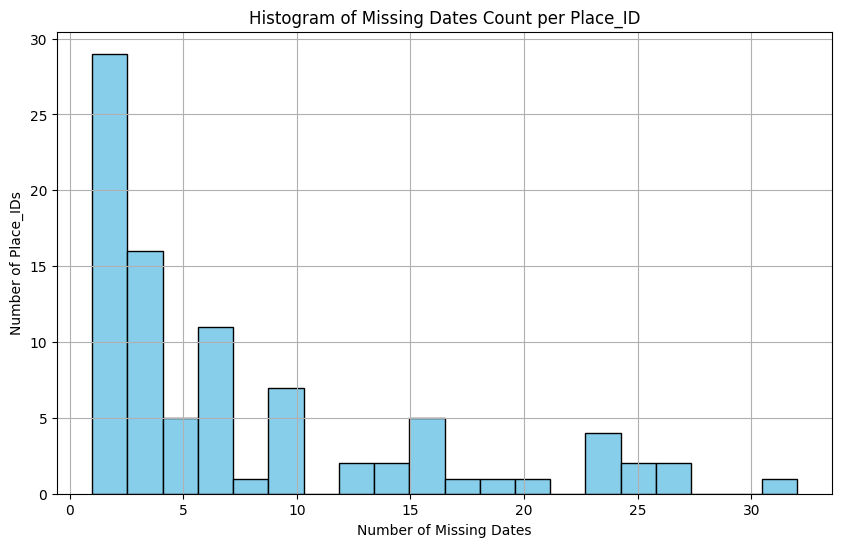

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of missing dates count per Place_ID
plt.figure(figsize=(10, 6))
plt.hist(missing_rows['missing_dates_count'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Number of Missing Dates')
plt.ylabel('Number of Place_IDs')
plt.title('Histogram of Missing Dates Count per Place_ID')
plt.grid(True)
plt.show()

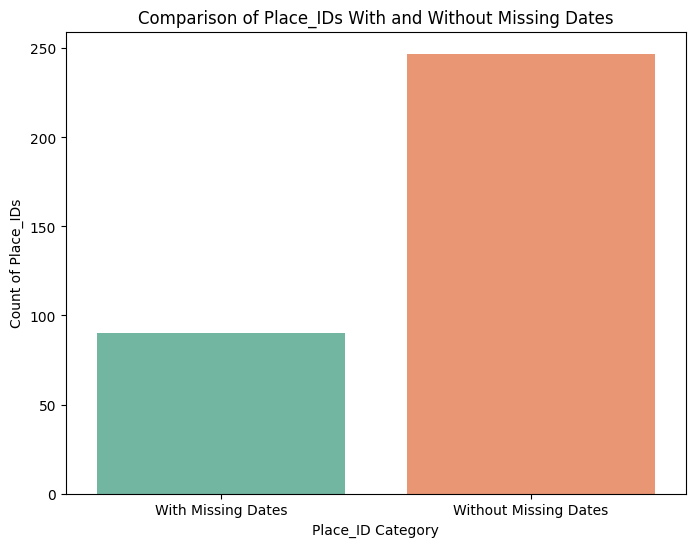

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `missing_dates_df` contains columns ['Place_ID', 'missing_dates_count']

# Separate Place_IDs into two groups based on whether they have missing dates or not
place_ids_with_missing = missing_dates_df[missing_dates_df['missing_dates_count'] > 0]['Place_ID']
place_ids_without_missing = missing_dates_df[missing_dates_df['missing_dates_count'] == 0]['Place_ID']

# Count how many Place_IDs in each group
num_with_missing = len(place_ids_with_missing)
num_without_missing = len(place_ids_without_missing)

# Create a comparison dataframe
comparison_data = pd.DataFrame({
    'Category': ['With Missing Dates', 'Without Missing Dates'],
    'Count': [num_with_missing, num_without_missing]
})

# Bar Plot to compare Place_IDs with and without missing dates
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=comparison_data, palette='Set2')

# Add labels and title
plt.xlabel('Place_ID Category')
plt.ylabel('Count of Place_IDs')
plt.title('Comparison of Place_IDs With and Without Missing Dates')
plt.show()

In [ ]:
# drop 

# Function to find missing dates for each Place_ID
def check_missing_dates(df):
    missing_info = []
    
    # Group by Place_ID
    grouped = df.groupby('Place_ID')
    
    for place_id, group in grouped:
        # Sort the group by 'Date'
        group = group.sort_values(by='Date')
        
        # Get min and max date for the current Place_ID
        min_date = group['Date'].min()
        max_date = group['Date'].max()
        
        # Generate the full range of dates
        full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')
        
        # Find actual dates in the group
        actual_dates = group['Date'].unique()
        
        # Identify missing dates
        missing_dates = set(full_date_range) - set(actual_dates)
        
        # Append result for this Place_ID
        missing_info.append({
            'Place_ID': place_id,
            'min_date': min_date,
            'max_date': max_date,
            'expected_dates': len(full_date_range),
            'actual_dates': len(actual_dates),
            'missing_dates_count': len(missing_dates),
            'missing_dates': sorted(missing_dates)
        })
    
    return pd.DataFrame(missing_info)

# Run the function to check missing dates for both train and test data
missing_dates_train_df = check_missing_dates(df_train_split)
missing_dates_test_df = check_missing_dates(df_test_split)

# Combine Place_IDs with missing dates from both train and test sets
place_ids_with_missing_dates_train = missing_dates_train_df[missing_dates_train_df['missing_dates_count'] > 0]['Place_ID'].tolist()
place_ids_with_missing_dates_test = missing_dates_test_df[missing_dates_test_df['missing_dates_count'] > 0]['Place_ID'].tolist()

# Union of both sets of Place_IDs (train and test)
place_ids_with_missing_dates = set(place_ids_with_missing_dates_train).union(place_ids_with_missing_dates_test)

# Filter df_train_split and df_test_split to exclude Place_IDs with missing dates
df_train_cleaned = df_train_split[~df_train_split['Place_ID'].isin(place_ids_with_missing_dates)]
df_test_cleaned = df_test_split[~df_test_split['Place_ID'].isin(place_ids_with_missing_dates)]

# Check the result
print(f"Number of rows in cleaned train set: {len(df_train_cleaned)}")
print(f"Number of rows in cleaned test set: {len(df_test_cleaned)}")


Number of rows in cleaned train set: 21985
Number of rows in cleaned test set: 738


In [ ]:
# Initial number of unique Place_IDs
initial_place_ids_train = df_train_split['Place_ID'].nunique()
initial_place_ids_test = df_test_split['Place_ID'].nunique()

# Number of unique Place_IDs with missing dates
dropped_place_ids_train = len(set(place_ids_with_missing_dates_train))
dropped_place_ids_test = len(set(place_ids_with_missing_dates_test))

# Cleaned number of unique Place_IDs
cleaned_place_ids_train = df_train_cleaned['Place_ID'].nunique()
cleaned_place_ids_test = df_test_cleaned['Place_ID'].nunique()

# Calculate how many were dropped
dropped_count_train = initial_place_ids_train - cleaned_place_ids_train
dropped_count_test = initial_place_ids_test - cleaned_place_ids_test

# Display results
print(f"Initial unique Place_IDs in training set: {initial_place_ids_train}")
print(f"Dropped Place_IDs from training set: {dropped_count_train}")

print(f"\nInitial unique Place_IDs in test set: {initial_place_ids_test}")
print(f"Dropped Place_IDs from test set: {dropped_count_test}")

# Total dropped Place_IDs
total_dropped = dropped_count_train + dropped_count_test
print(f"\nTotal Place_IDs dropped: {total_dropped}")


Initial unique Place_IDs in training set: 337
Dropped Place_IDs from training set: 91

Initial unique Place_IDs in test set: 337
Dropped Place_IDs from test set: 91

Total Place_IDs dropped: 182


In [ ]:
df_train_cleaned = df_train_split
df_test_cleaned = df_test_split

# ___________


# trying to merge with code from apo branch


In [ ]:
# Assuming 'target' is sorted by 'Date' within each 'Place_ID'
df_test_split['lag_1'] = df_test_split.groupby('Place_ID')['target'].shift(1)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Define the list of numerical features (excluding 'Place_ID', 'Date', 'lag1', and 'target')
numerical_features = list(set(df_train_split.columns) - set(['Place_ID', 'Date', 'lag_1', 'target']))
categorical_features = ['Place_ID']  # Categorical feature

# Step 1: Create pipelines for both numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Apply OneHotEncoding to categorical features
])

# Combine the numerical and categorical pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Step 2: Define the base models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Step 3: Create a pipeline that includes the preprocessing and the model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_model)])
gbr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', gbr)])

# Prepare the train and test data (ensure both have the same columns, including 'Place_ID')
X_train = df_train_split[numerical_features + ['Place_ID', 'lag_1']]  # Use Place_ID and lag1 as well
y_train = df_train_split['target']

X_test = df_test_split[numerical_features + ['Place_ID', 'lag_1']]  # Ensure test set has same columns
y_test = df_test_split['target']

# Step 4: Train the base models
rf_pipeline.fit(X_train, y_train)
gbr_pipeline.fit(X_train, y_train)

# Step 5: Use cross-validation to get out-of-fold predictions for meta-model training
kf = KFold(n_splits=5, shuffle=True, random_state=42)

meta_train = np.zeros((len(X_train), 2))  # 2 base models: rf and gbr
meta_test = np.zeros((len(X_test), 2))  # Hold predictions for test data

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train models on training fold
    rf_pipeline.fit(X_tr, y_tr)
    gbr_pipeline.fit(X_tr, y_tr)

    # Get predictions for validation fold
    meta_train[val_idx, 0] = rf_pipeline.predict(X_val)  # RF predictions
    meta_train[val_idx, 1] = gbr_pipeline.predict(X_val)  # GBR predictions

    # Get predictions for the test set (average over folds)
    meta_test[:, 0] += rf_pipeline.predict(X_test) / kf.n_splits
    meta_test[:, 1] += gbr_pipeline.predict(X_test) / kf.n_splits

# Step 6: Train the meta-model (Ridge regression)
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_train, y_train)

# Step 7: Make predictions on the test set using the meta-model
final_predictions = meta_model.predict(meta_test)

# Step 8: Calculate RMSE for the stacked model
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print("Root Mean Squared Error of the stacked model:", final_rmse)


ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: '010Q650 X 2020-01-03'